In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision

from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_style("darkgrid")

from mean_teacher import datasets, architectures
from mean_teacher.utils import *

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
to_image = transforms.ToPILImage()

%matplotlib inline

In [3]:
def load_weights(model_arch, pretrained_model_path, state_dict, cuda=True):
        # Load pretrained model
        pretrained_model = torch.load(f=pretrained_model_path, map_location="cuda" if cuda else "cpu")

        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in pretrained_model[state_dict].items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

        # Load pre-trained weights in current model
        with torch.no_grad():
            model_arch.load_state_dict(new_state_dict, strict=True)

        # Debug loading
        #print('Parameters found in pretrained model:')
        pretrained_layers = new_state_dict.keys()
        #for l in pretrained_layers:
        #    print('\t' + l)
        #print('')

        for name, module in model_arch.state_dict().items():
            if name in pretrained_layers:
                assert torch.equal(new_state_dict[name].cpu(), module.cpu())
                #print('{} have been loaded correctly in current model.'.format(name))
            else:
                raise ValueError("state_dict() keys do not match")
                
        return model_arch


In [4]:
dataset_config = datasets.__dict__['sslMini']()

In [5]:
BATCH_SIZE = 32

evaldir = "/scratch/ijh216/ssl_mini/supervised/val"

eval_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(evaldir, dataset_config['eval_transformation']),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=2,
                                              drop_last=False)


In [6]:
img_dir = eval_loader.dataset.imgs[0][0]
img = eval_loader.dataset[0][0].unsqueeze(0).to(device).detach()
img_class = eval_loader.dataset[0][1]

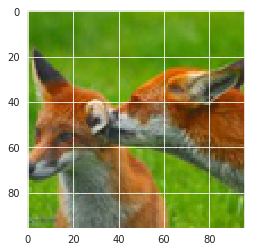

In [7]:
plt.imshow(io.imread(img_dir))

In [9]:
model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(0) 
model = architectures.__dict__['cifar_shakeshake26']().to(device)
model = load_weights(model, model_dir, state_dict="ema_state_dict", cuda=False)
labels = F.softmax(model(img)[0], dim=1)

for ckpt in tqdm(range(25, 325, 25)):

    model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(ckpt) 
    model = architectures.__dict__['cifar_shakeshake26']().to(device)
    model = load_weights(model, model_dir, state_dict="ema_state_dict", cuda=False)


    output = F.softmax(model(img)[0], dim=1)
    labels = torch.cat((labels, output))
    
labels_df = pd.DataFrame(labels.detach().numpy())
labels_df.index.name = "ckpt"

labels_df_melt = pd.melt(labels_df.reset_index(), id_vars=['ckpt'], var_name='label', value_name='est')


100%|██████████| 12/12 [00:35<00:00,  2.72s/it]

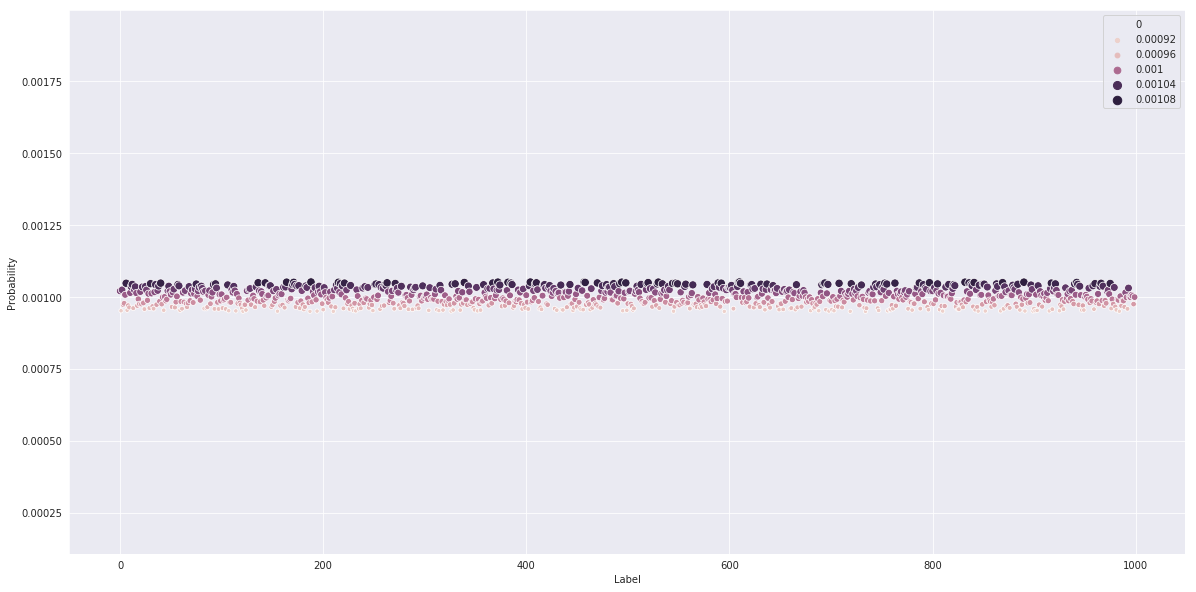

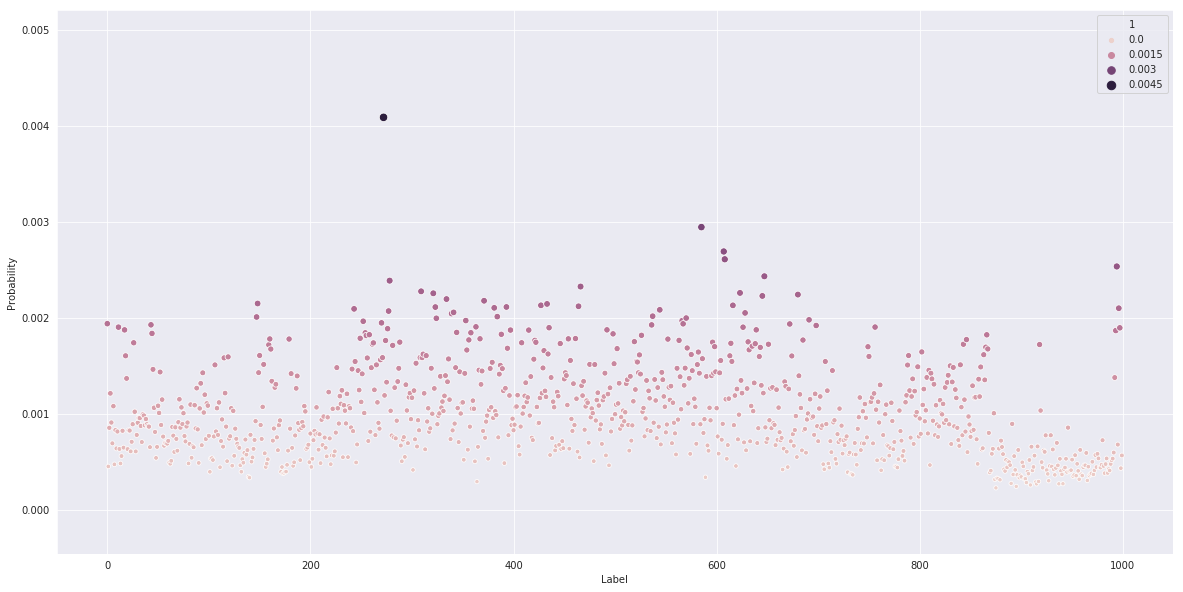

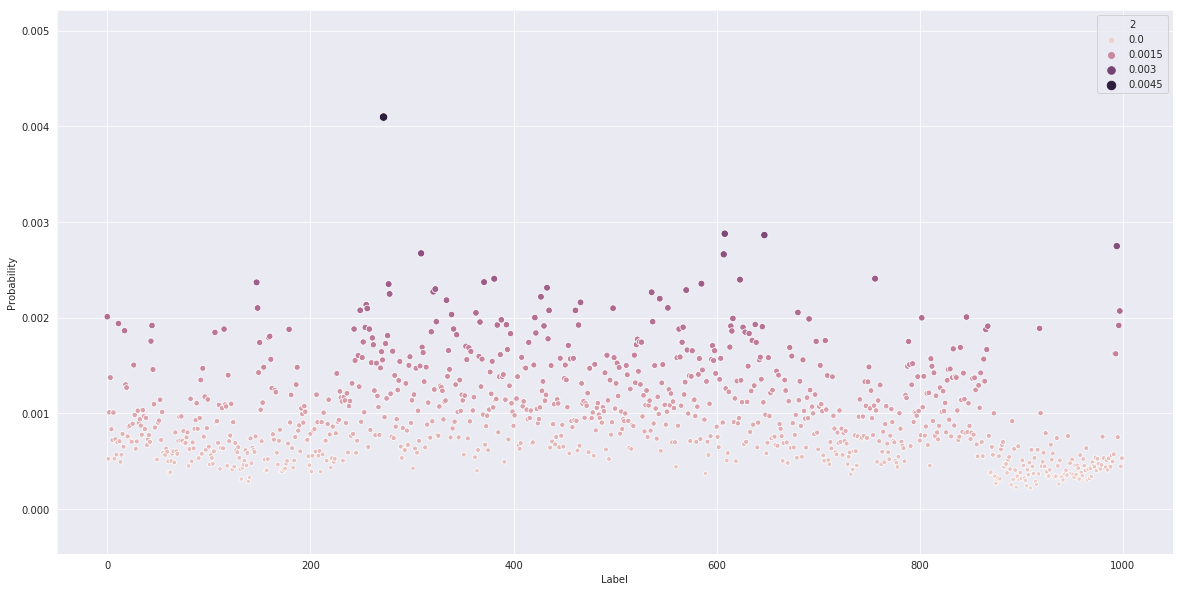

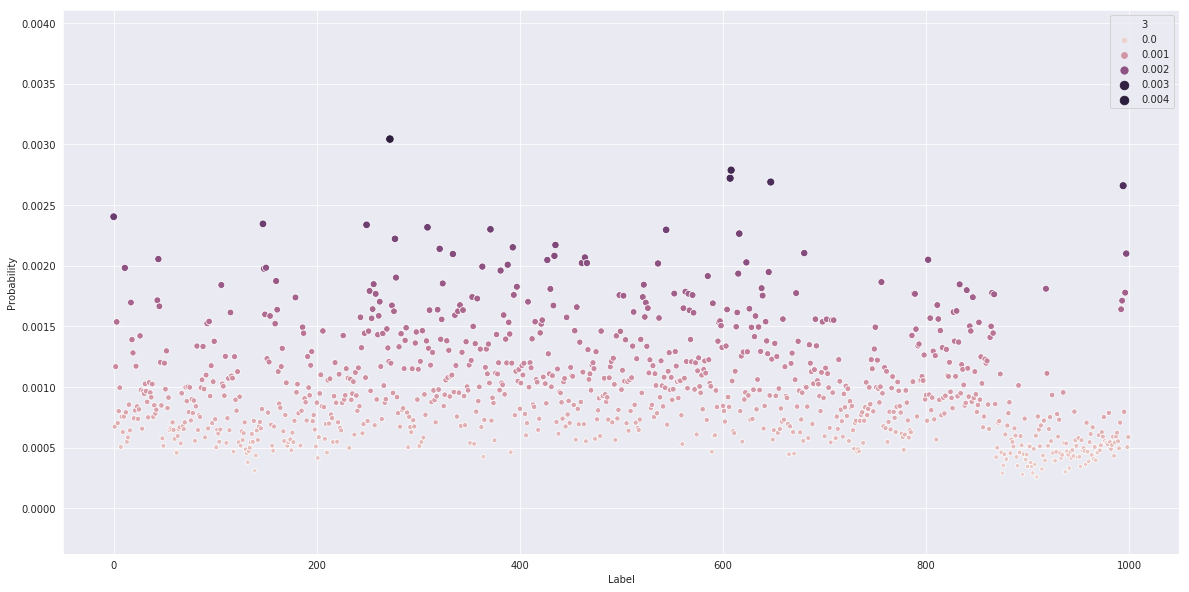

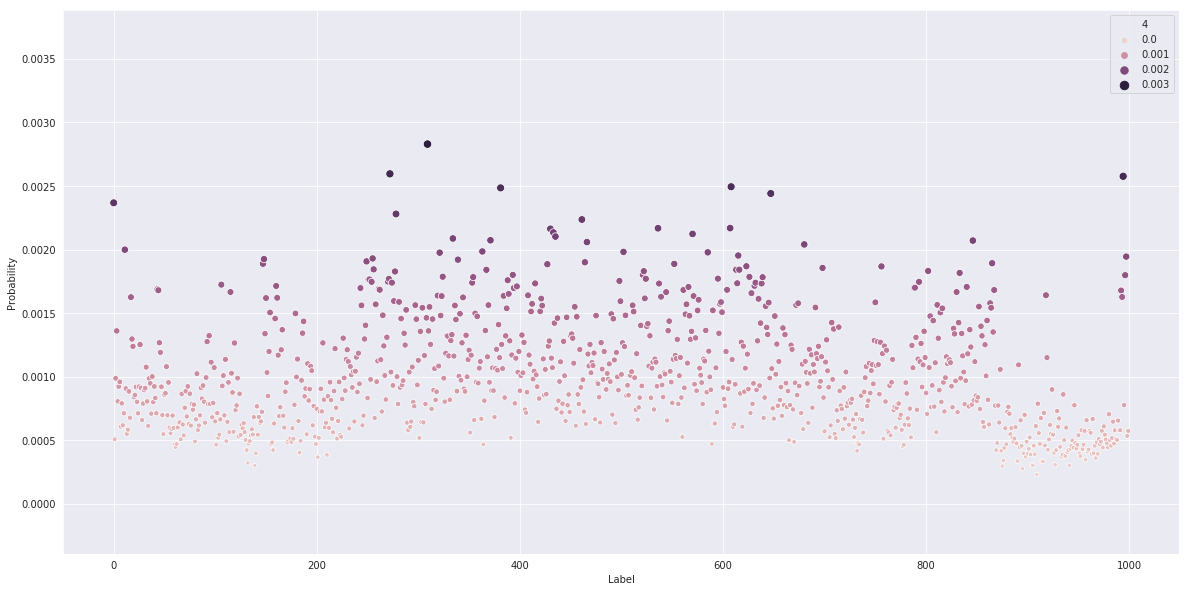

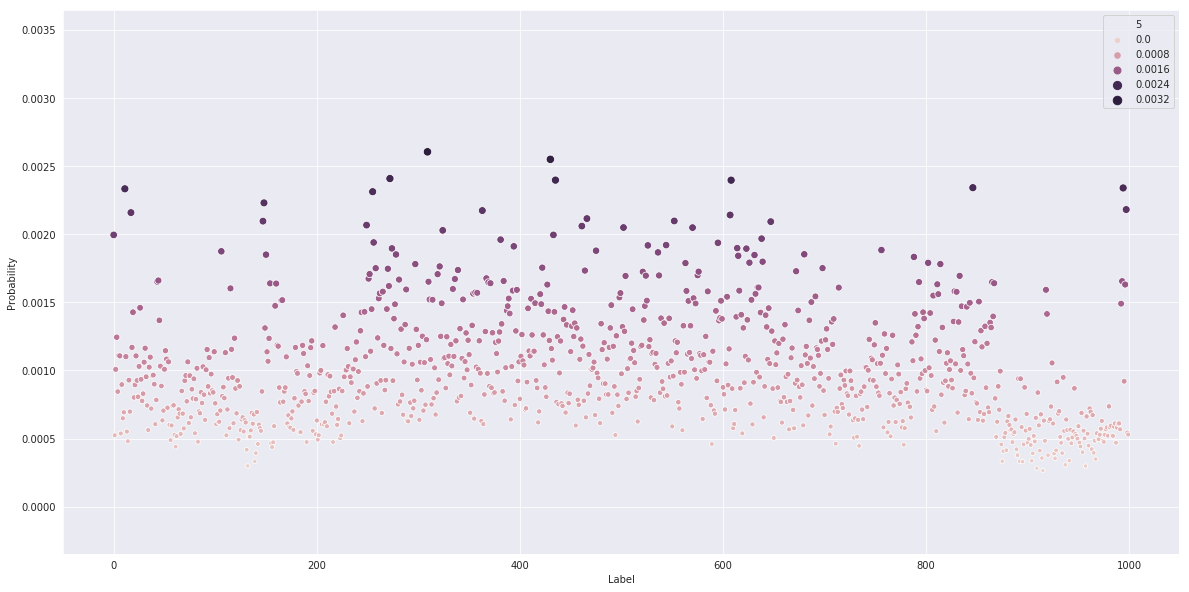

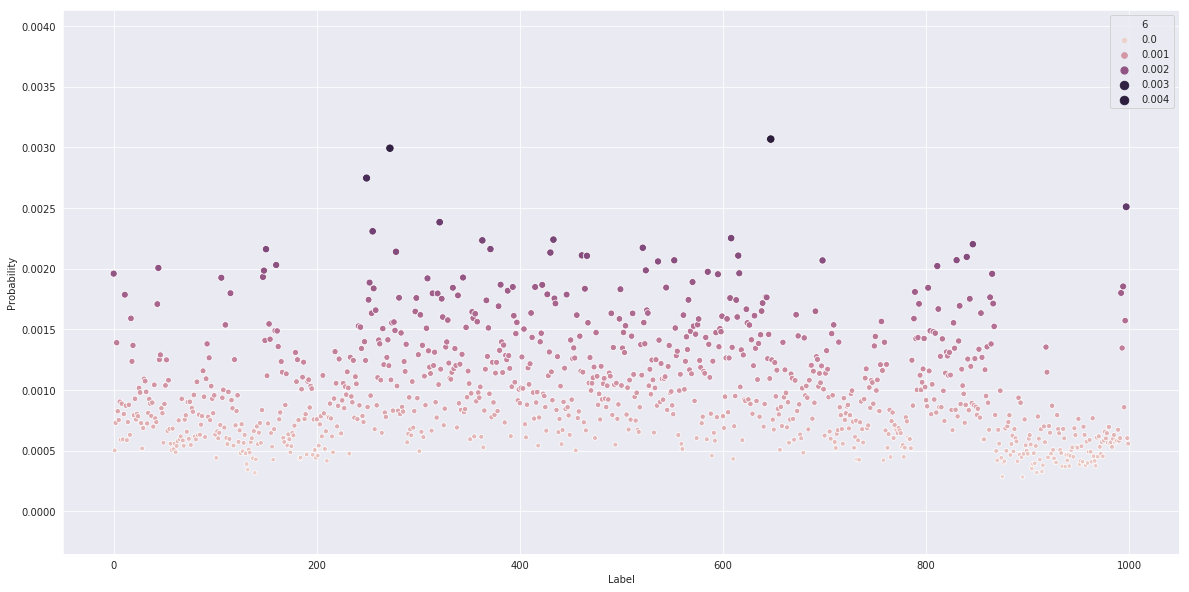

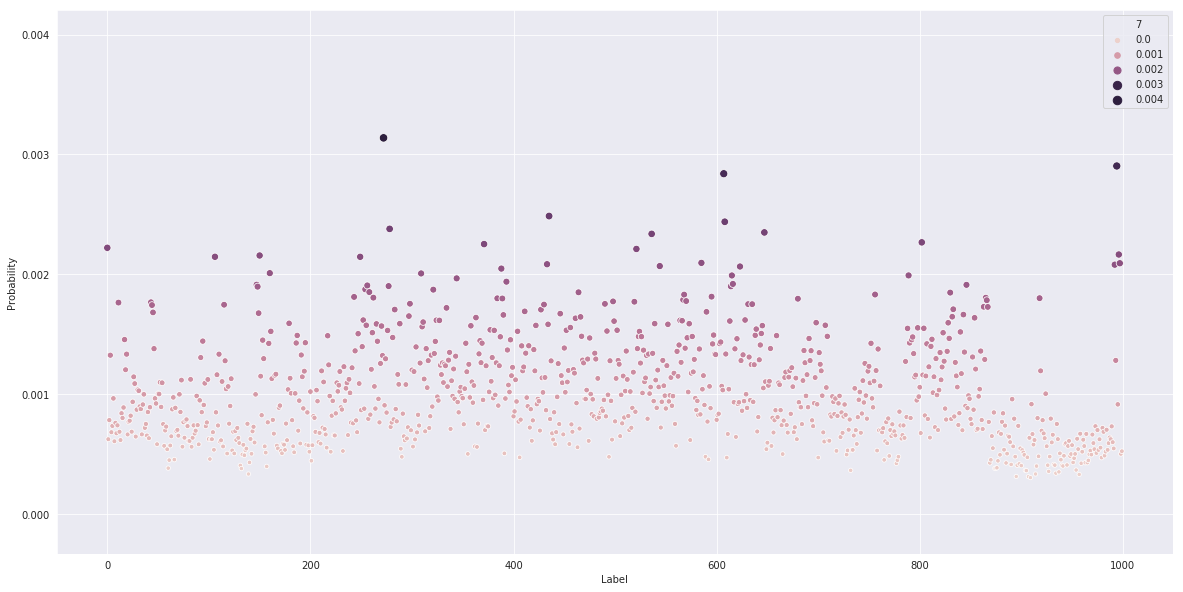

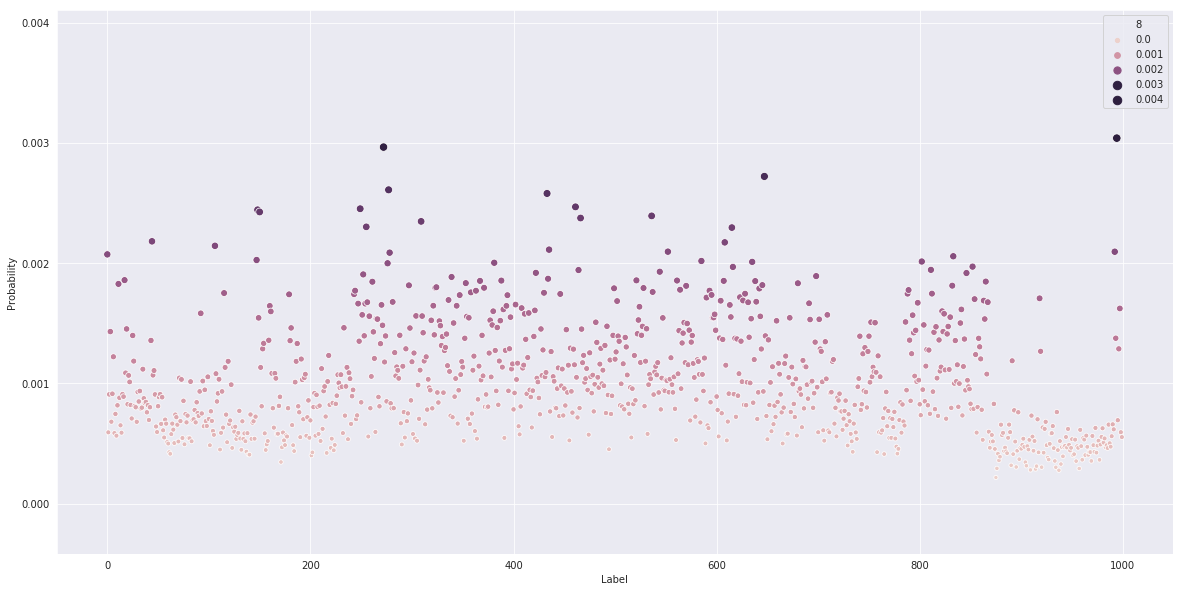

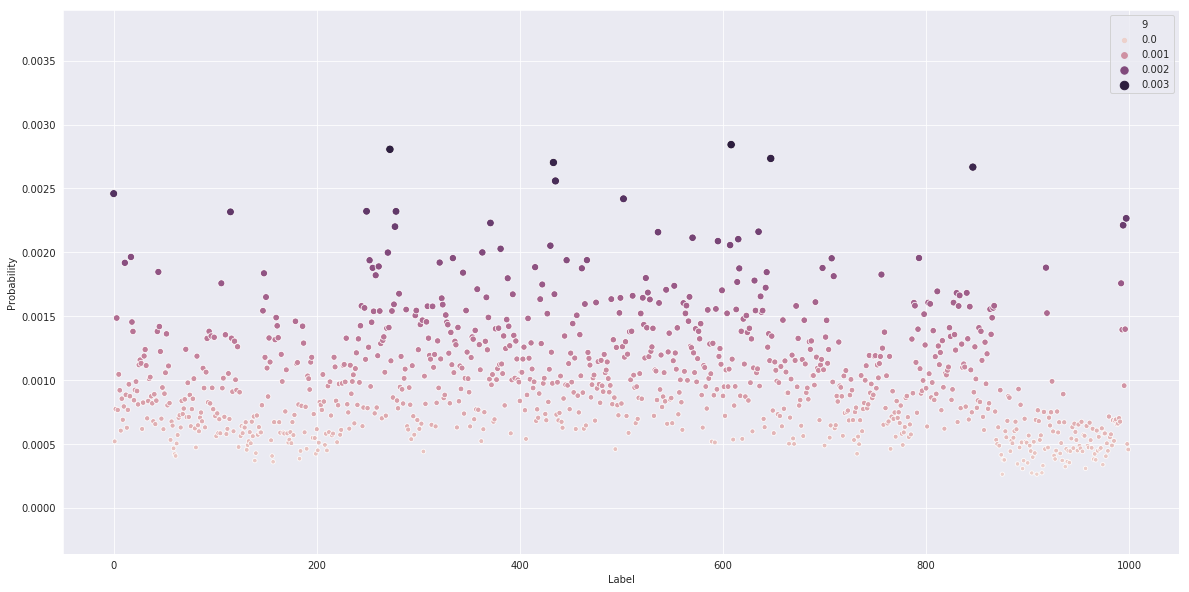

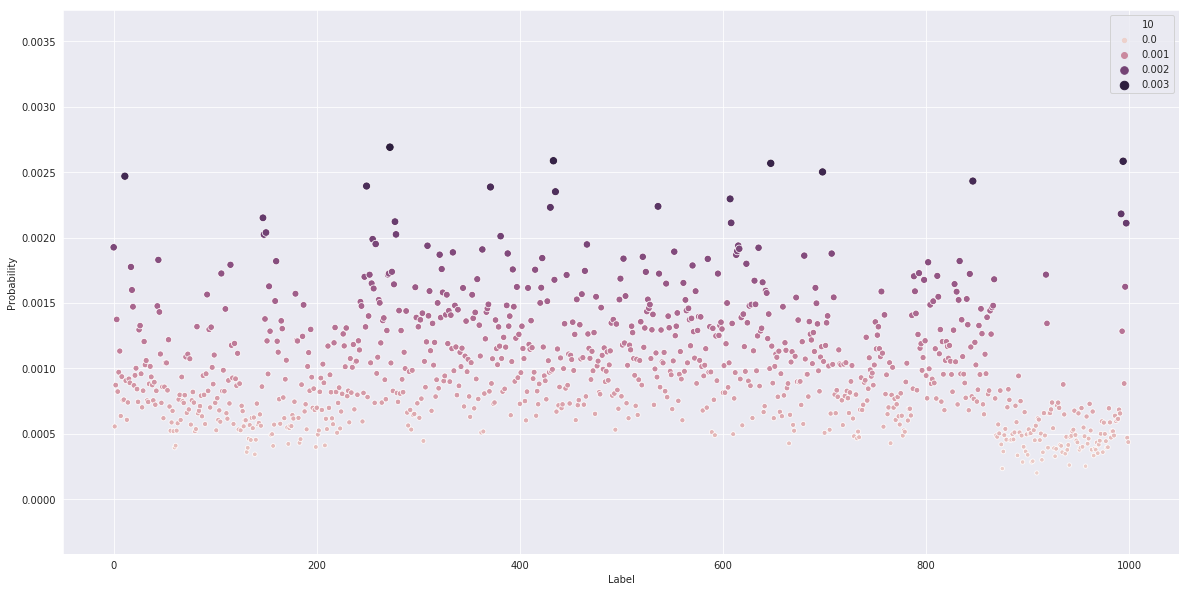

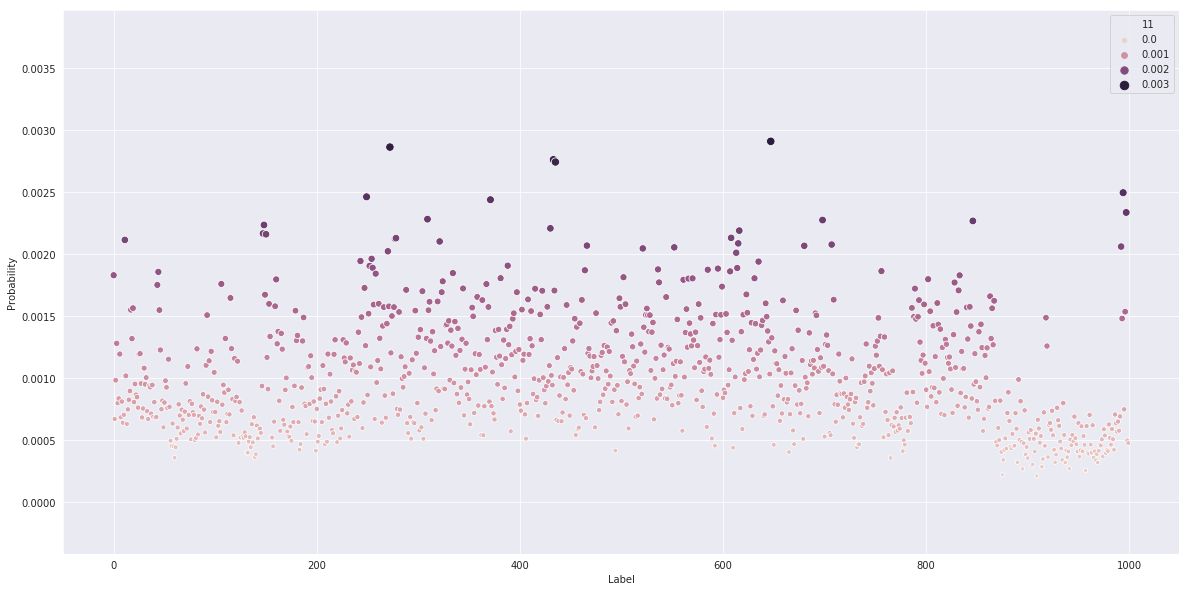

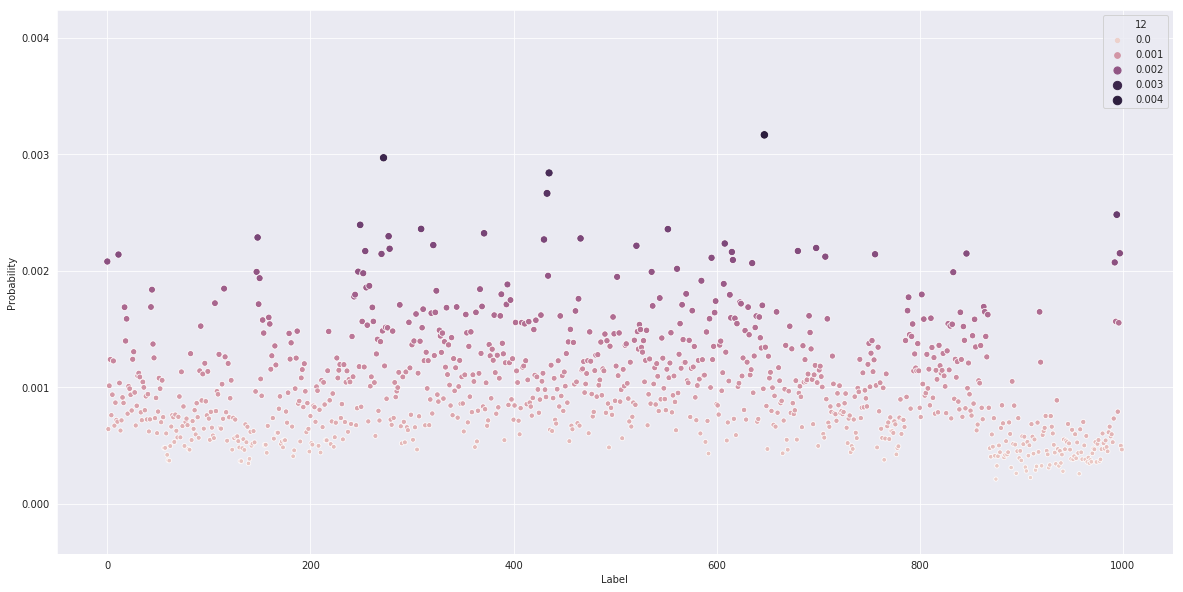

In [11]:
for i in range(labels_df.shape[0]):
    
    labels_ckpt = labels_df.iloc[i]
    
    fig = plt.figure(figsize=(20,10))
    sns.scatterplot(x = labels_df.columns, 
                    y = labels_ckpt, 
                    hue = labels_ckpt, 
                    size = labels_ckpt)
    plt.xlabel("Label")
    plt.ylabel("Probability")

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/scipy-1.0.0rc1-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


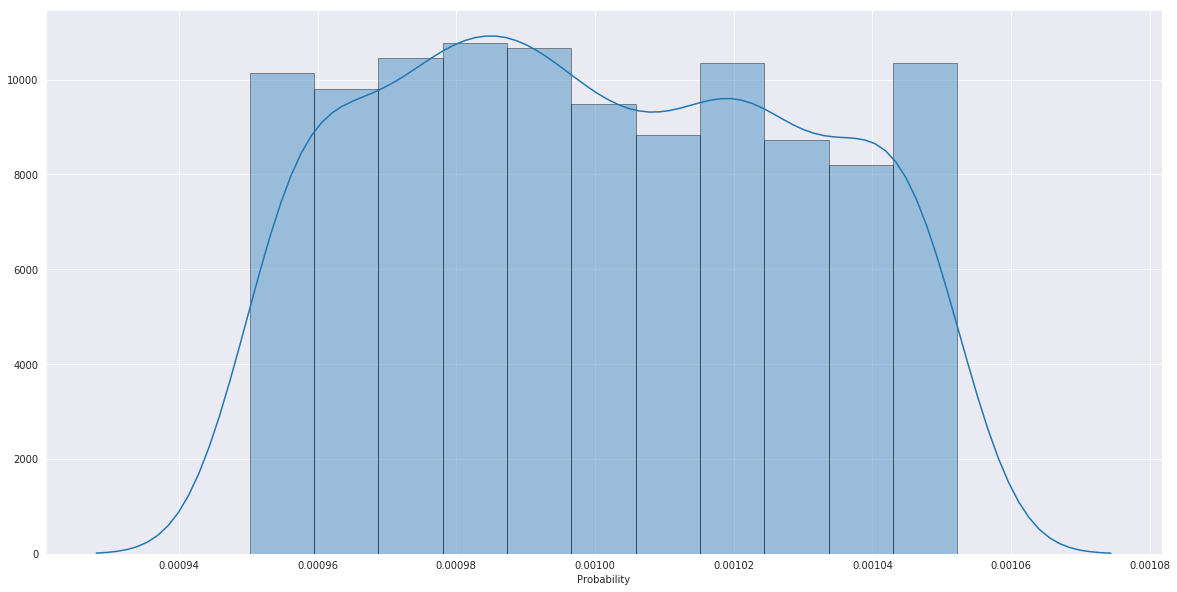

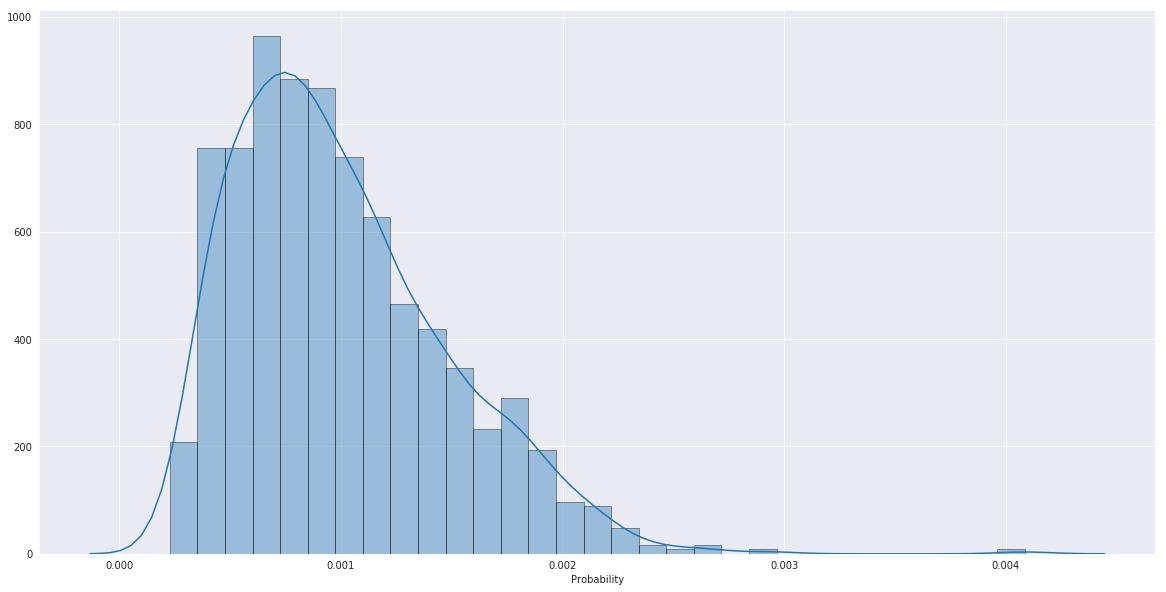

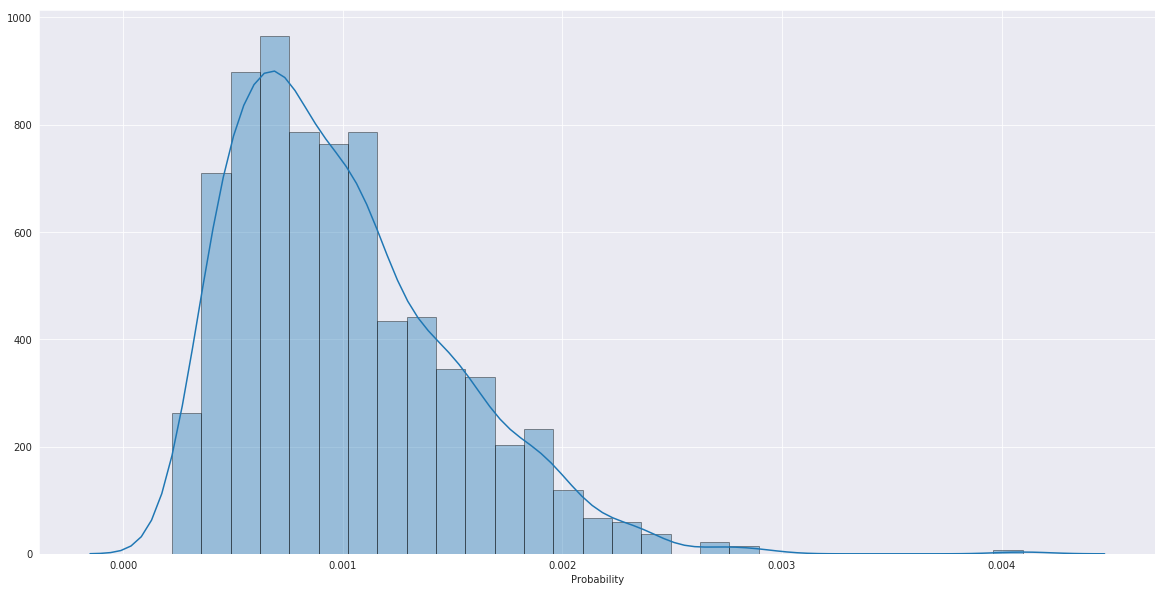

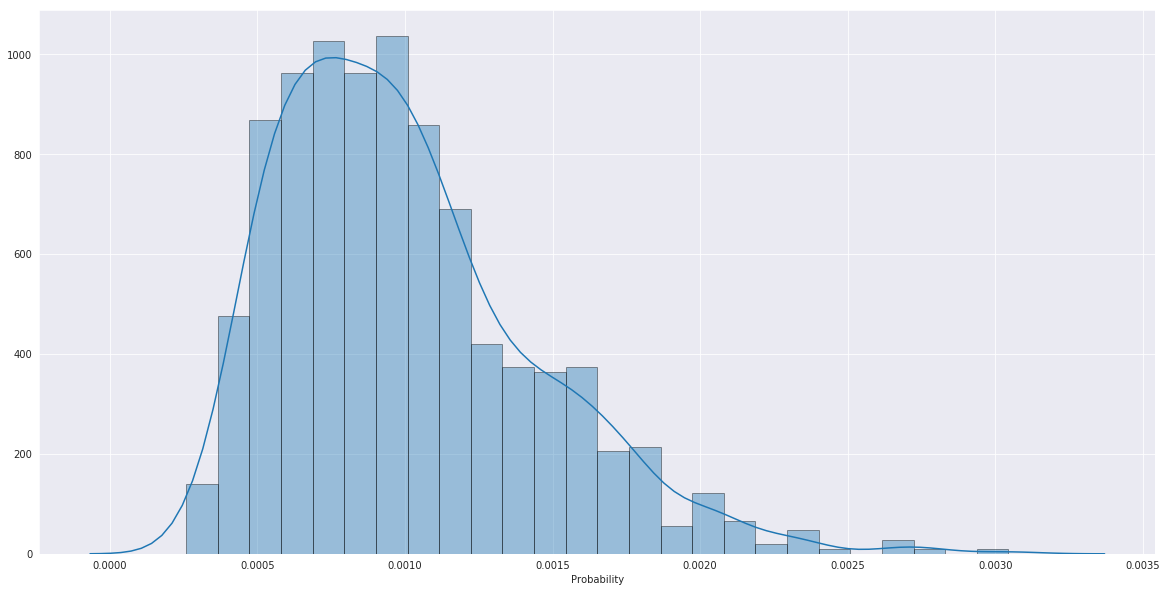

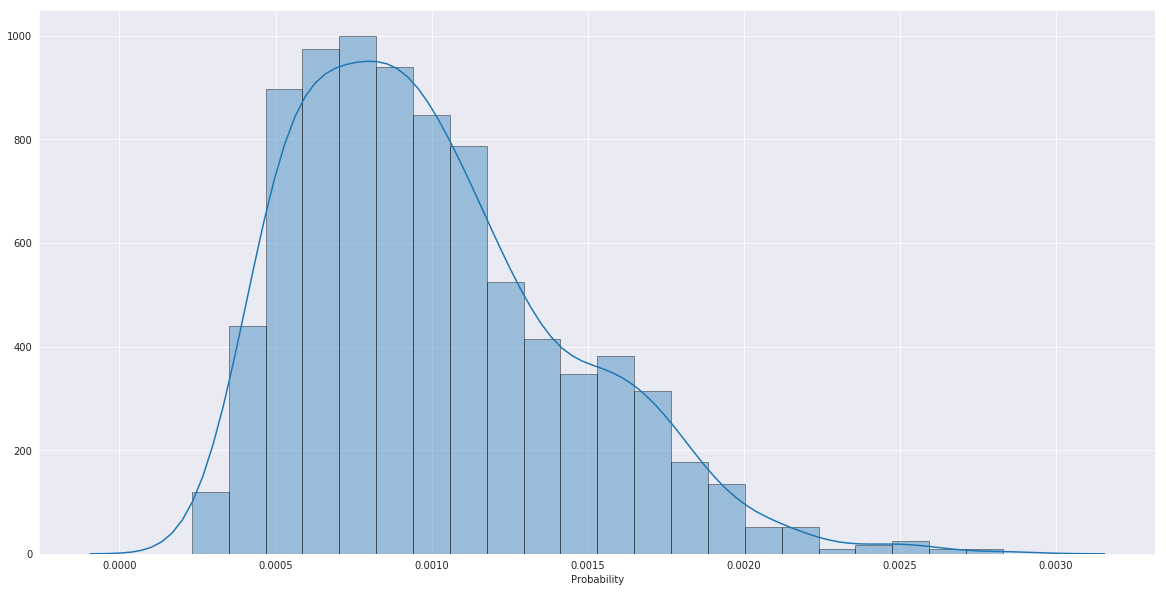

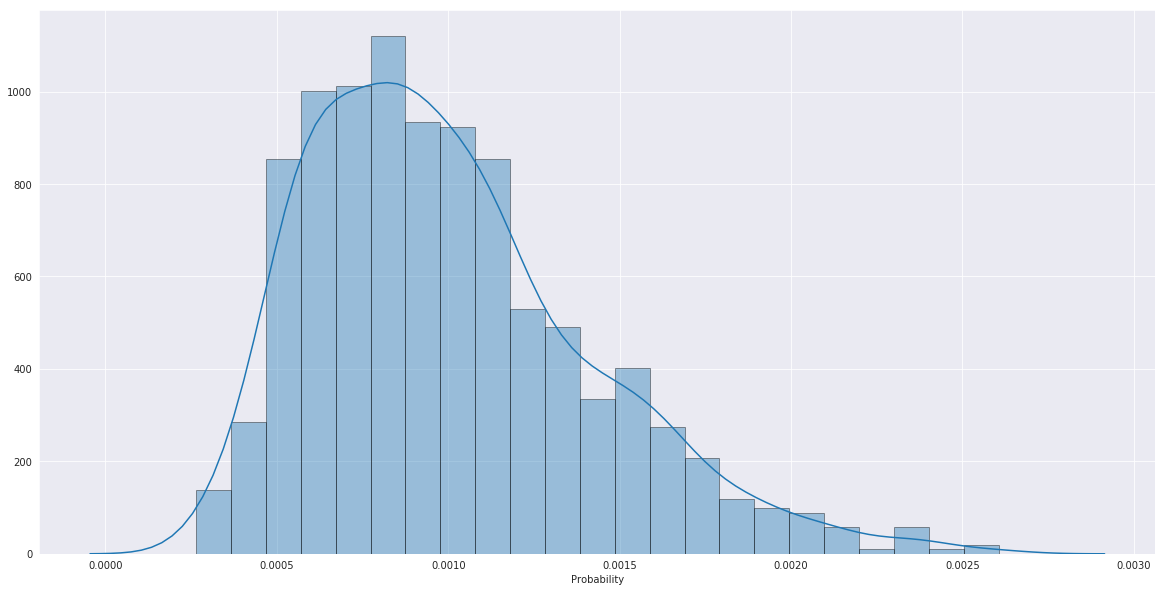

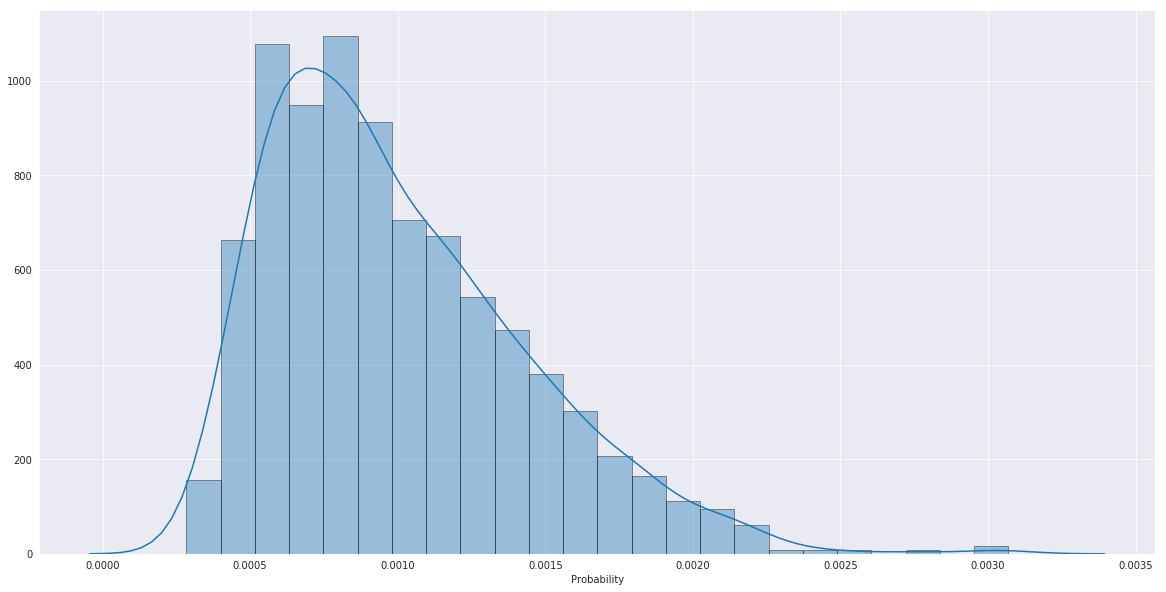

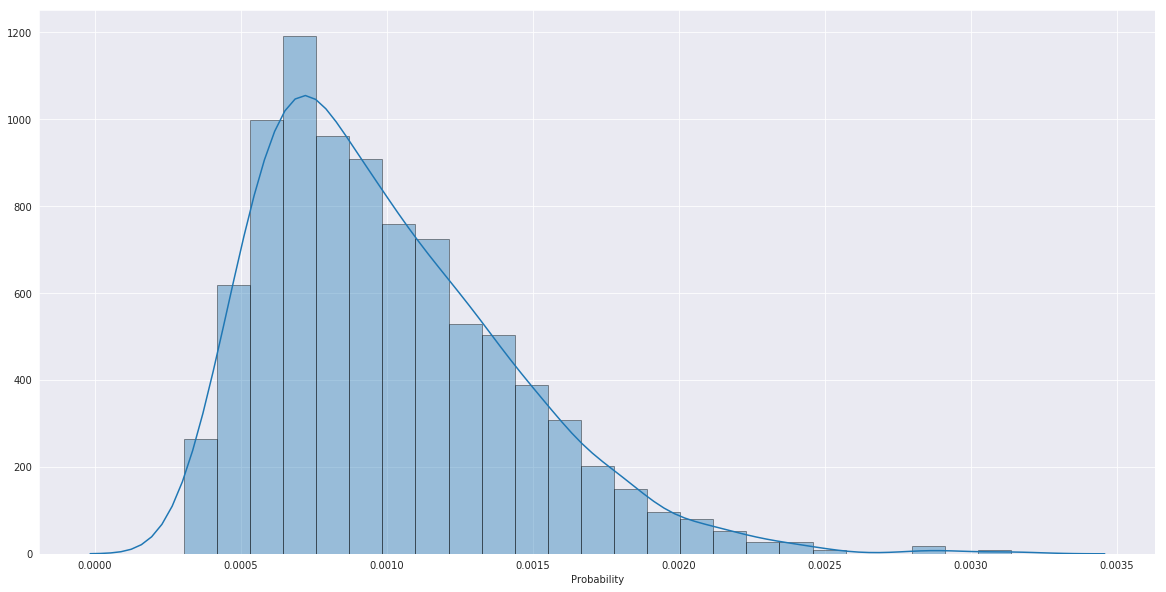

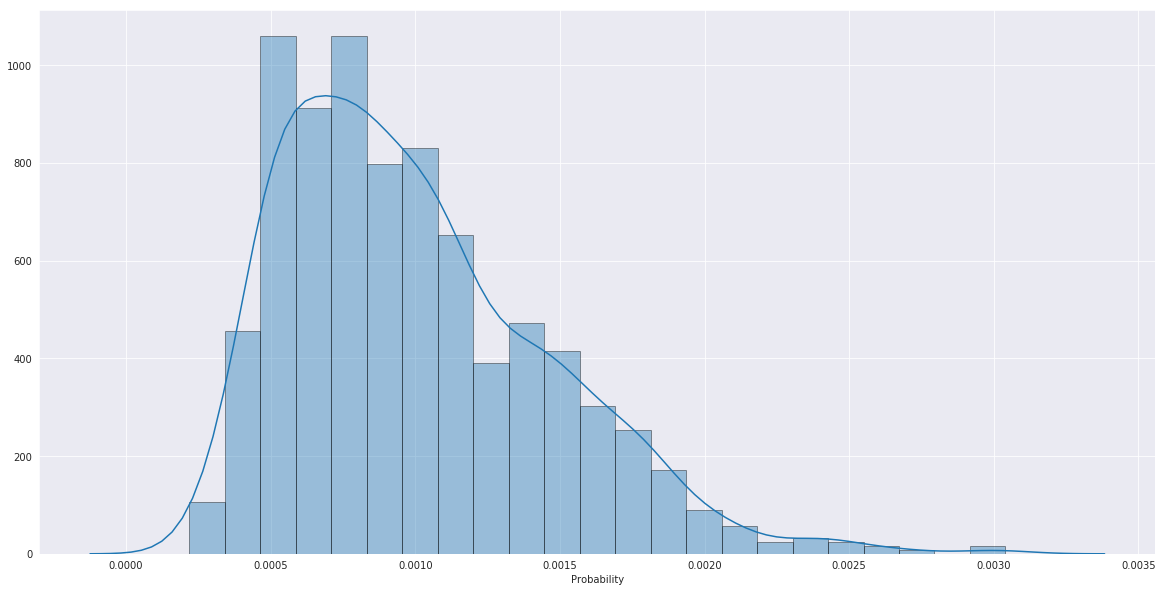

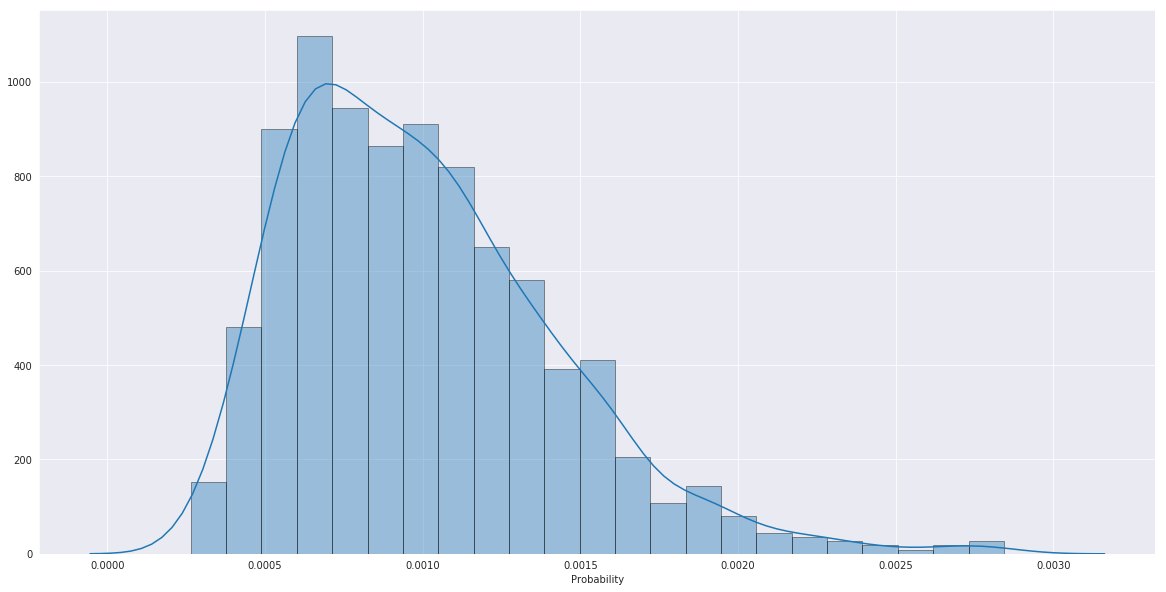

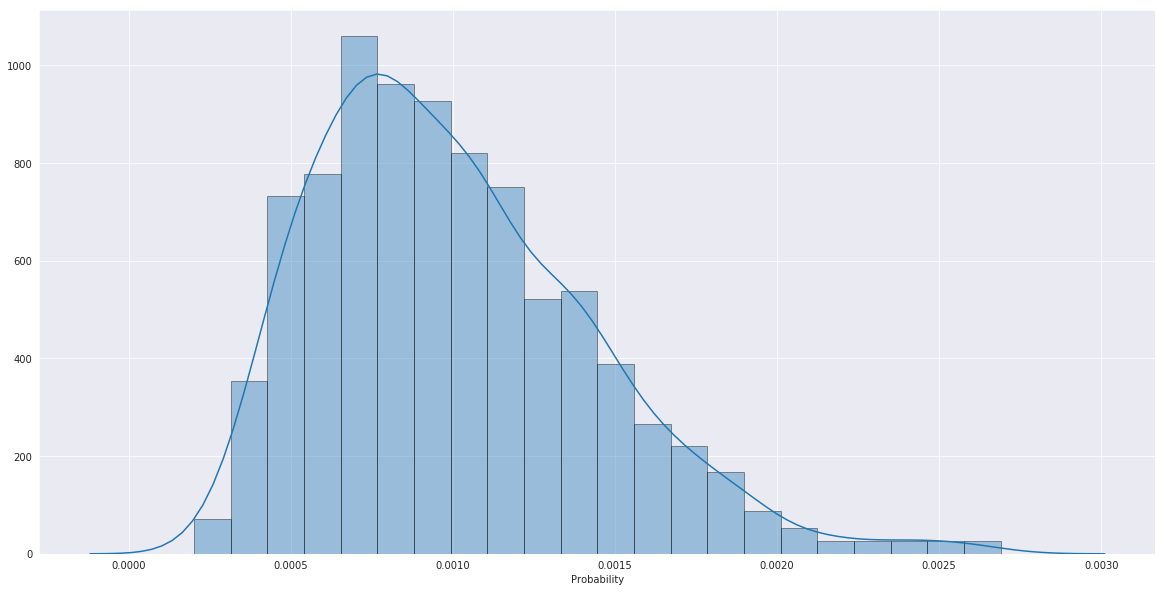

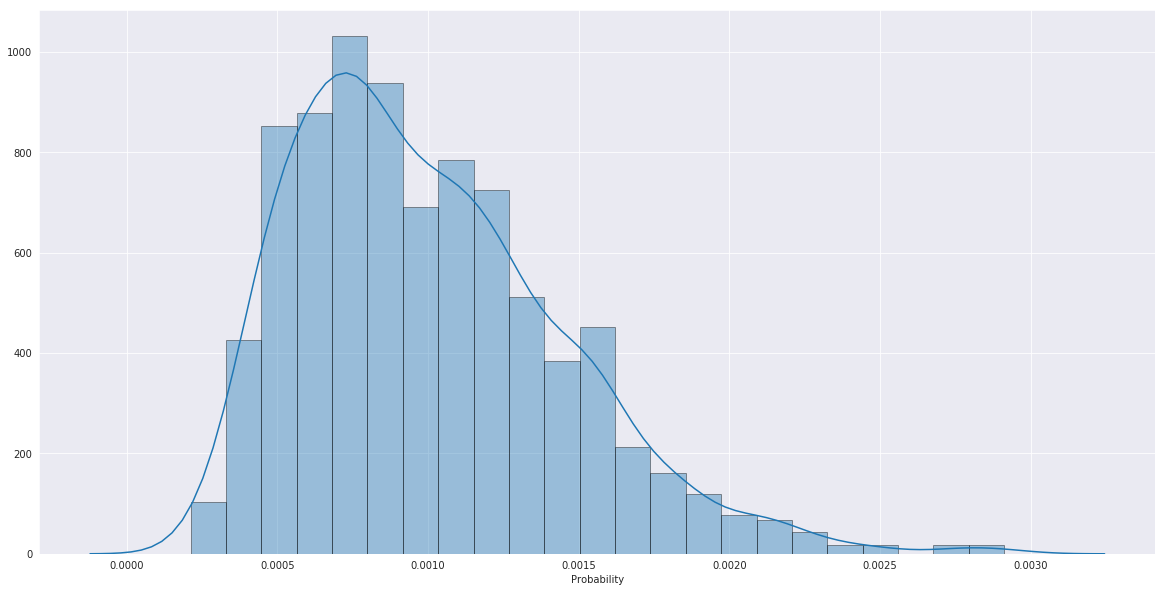

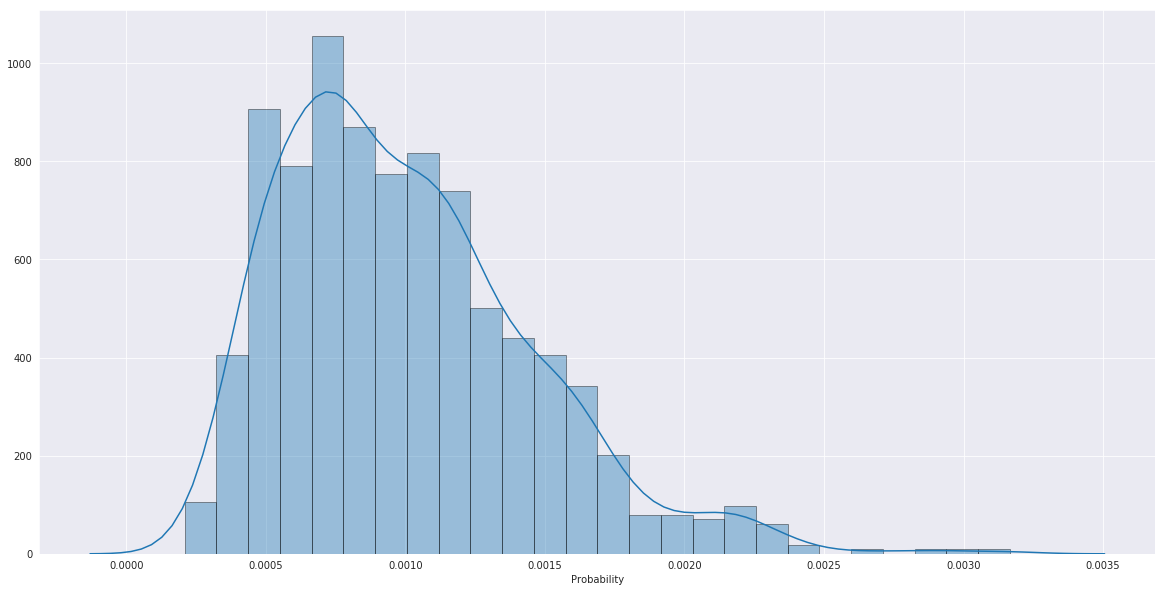

In [12]:
for i in range(labels_df.shape[0]):
    
    labels_ckpt = labels_df.iloc[i]
    
    fig = plt.figure(figsize=(20,10))
    sns.distplot(a = labels_ckpt,
                hist=True,
                kde=True,
                norm_hist=True,
                hist_kws={'edgecolor':'black'},
                label="Checkpoint {}".format(int(i * 25)),
                axlabel='Probability')

In [13]:
model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(0) 

model = architectures.__dict__['cifar_shakeshake26']().to(device)
ema_model = architectures.__dict__['cifar_shakeshake26']().to(device)

model = load_weights(model, model_dir, state_dict="state_dict", cuda=False)
ema_model = load_weights(ema_model, model_dir, state_dict="ema_state_dict", cuda=False)

model_out = F.softmax(model(img)[0], dim=1)
ema_model_out = F.softmax(ema_model(img)[0], dim=1)

dists = torch.cat((model_out, ema_model_out)).unsqueeze(0)

for ckpt in tqdm(range(25, 325, 25)):
    model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(0) 

    model = architectures.__dict__['cifar_shakeshake26']().to(device)
    ema_model = architectures.__dict__['cifar_shakeshake26']().to(device)

    model = load_weights(model, model_dir, state_dict="state_dict", cuda=False)
    ema_model = load_weights(ema_model, model_dir, state_dict="ema_state_dict", cuda=False)

    model_out = F.softmax(model(img)[0], dim=1)
    ema_model_out = F.softmax(ema_model(img)[0], dim=1)
    
    outs = torch.cat((model_out, ema_model_out)).unsqueeze(0)
    dists = torch.cat((dists, outs))
    


100%|██████████| 12/12 [00:36<00:00,  2.80s/it]

In [16]:
dists.size()

torch.Size([13, 2, 1000])

In [18]:
dists[0].size()

torch.Size([2, 1000])